In [31]:
!pip install seaborn
!pip install xgboost
!pip install tabulate

  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)


In [28]:
# Importaciones necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import xgboost as xgb
import warnings
import json
import time

from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from mlflow.models import infer_signature
from sklearn.metrics import explained_variance_score
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [14]:
# Configurar el estilo de las visualizaciones
plt.style.use('default')
sns.set_theme()


# Experimentación con MLflow: Predicción de Tarifas de Taxi en NYC

Este proyecto demuestra el uso de MLflow para la experimentación y gestión de modelos de machine learning. Se trabaja con un dataset real de viajes de taxi en Nueva York para predecir tarifas, utilizando MLflow para registrar experimentos, comparar modelos y gestionar el ciclo de vida de los modelos.

## Objetivos

- Entrenar y comparar múltiples algoritmos de machine learning (regresión)
- Utilizar MLflow para registrar experimentos, métricas y modelos
- Ajustar hiperparámetros basándose en los resultados registrados en MLflow
- Comparar el rendimiento de diferentes algoritmos para seleccionar el mejor modelo
- Documentar el proceso de experimentación y los resultados obtenidos

In [15]:
# Configurar MLflow
mlflow.set_tracking_uri("http://localhost:5001")
mlflow.set_experiment("NYC_Taxi_Fare_Prediction")

<Experiment: artifact_location='mlflow-artifacts:/185818068821142822', creation_time=1740676779672, experiment_id='185818068821142822', last_update_time=1740676779672, lifecycle_stage='active', name='NYC_Taxi_Fare_Prediction', tags={}>

🏃 View run data_preparation_and_eda at: http://localhost:5001/#/experiments/185818068821142822/runs/af729ec633f54e6d9990d3a0be983f76
🧪 View experiment at: http://localhost:5001/#/experiments/185818068821142822


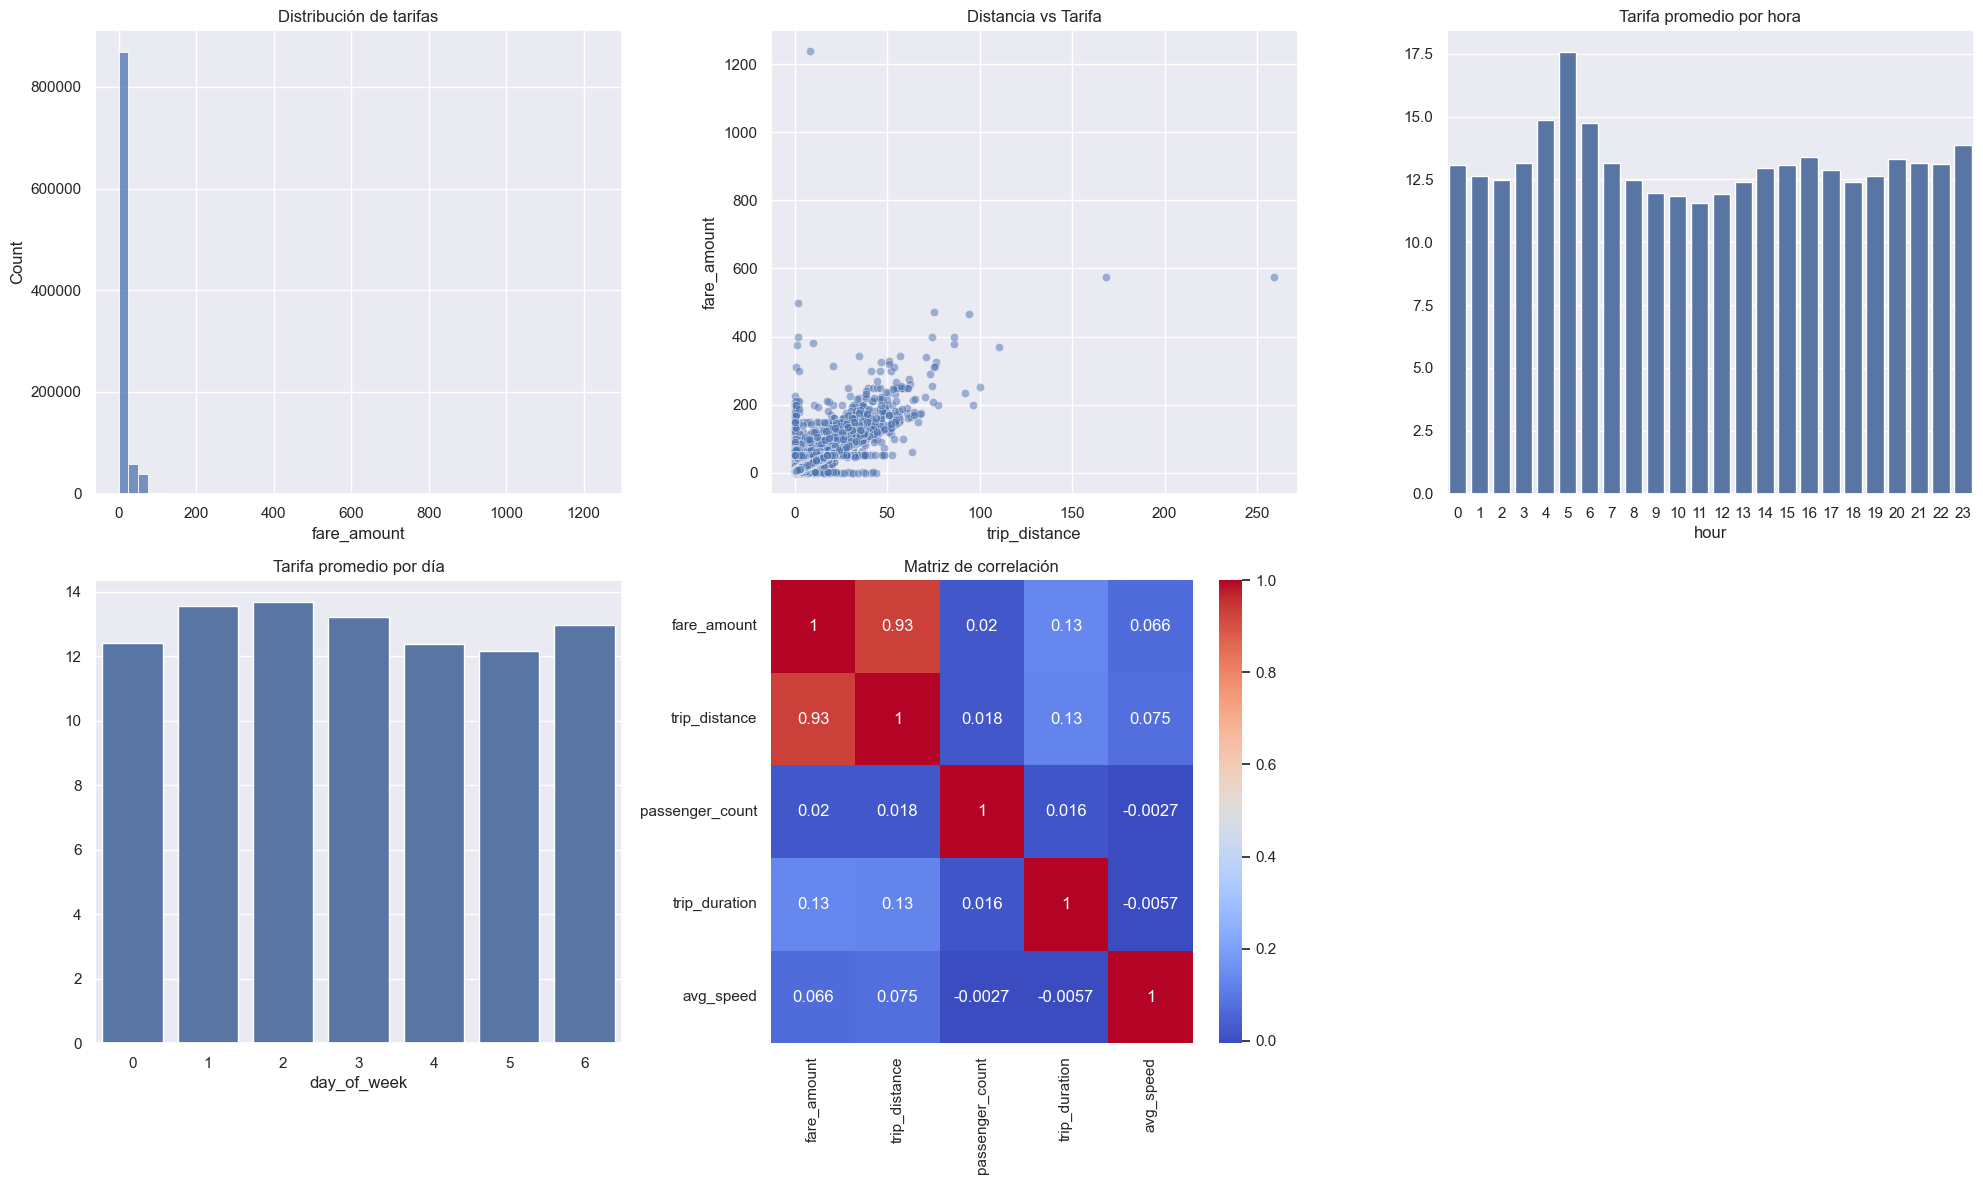

In [24]:
# Iniciar run para tracking del EDA y preprocesamiento
with mlflow.start_run(run_name="data_preparation_and_eda"):
    # 1. Carga de datos y registro de información inicial
    df = pd.read_csv('Taxi_Trip_Data.csv')
    df = df[0:1000000]
    
    initial_data_info = {
        "dataset_name": "NYC Taxi Trip Data",
        "initial_rows": len(df),
        "initial_columns": len(df.columns),
        "columns": list(df.columns),
        "missing_values": df.isnull().sum().to_dict(),
        "memory_usage": df.memory_usage(deep=True).sum() / 1024**2,  # En MB
        "data_types": df.dtypes.astype(str).to_dict()
    }
    
    # Logging información inicial
    mlflow.log_params(initial_data_info)
    mlflow.log_dict(initial_data_info, "initial_data_info.json")

    # 2. Preprocesamiento y Feature Engineering
    # Convertir fechas y crear features temporales
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
    
    preprocessing_steps = {
        "date_range": {
            "start_date": df['tpep_pickup_datetime'].min().strftime('%Y-%m-%d'),
            "end_date": df['tpep_pickup_datetime'].max().strftime('%Y-%m-%d')
        }
    }
    
    # Limpieza de datos
    initial_counts = len(df)
    df = df[df['fare_amount'] > 0]
    df = df[df['trip_distance'] > 0]
    df = df[df['passenger_count'] > 0]
    
    cleaning_impact = {
        "initial_rows": initial_counts,
        "rows_after_cleaning": len(df),
        "removed_rows": initial_counts - len(df),
        "removed_percentage": ((initial_counts - len(df)) / initial_counts) * 100
    }
    
    # Feature Engineering
    df['hour'] = df['tpep_pickup_datetime'].dt.hour
    df['day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
    df['month'] = df['tpep_pickup_datetime'].dt.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Duración del viaje
    df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60
    df = df[df['trip_duration'] > 0]
    
    # Velocidad promedio
    df['avg_speed'] = np.where(
        df['trip_duration'] > 0,
        df['trip_distance'] / (df['trip_duration'] / 60),
        0
    )
    df['avg_speed'] = df['avg_speed'].replace([np.inf, -np.inf], 0)
    
    feature_engineering_info = {
        "created_features": [
            "hour", "day_of_week", "month", "is_weekend",
            "trip_duration", "avg_speed"
        ],
        "rows_after_feature_engineering": len(df)
    }
    
    # Generar y guardar visualizaciones
    plt.figure(figsize=(20, 12))
    
    # Distribución de la tarifa
    plt.subplot(2, 3, 1)
    sns.histplot(data=df, x='fare_amount', bins=50)
    plt.title('Distribución de tarifas')
    
    # Relación distancia vs tarifa
    plt.subplot(2, 3, 2)
    sns.scatterplot(data=df, x='trip_distance', y='fare_amount', alpha=0.5)
    plt.title('Distancia vs Tarifa')
    
    # Tarifa promedio por hora
    plt.subplot(2, 3, 3)
    hourly_fares = df.groupby('hour')['fare_amount'].mean()
    sns.barplot(x=hourly_fares.index, y=hourly_fares.values)
    plt.title('Tarifa promedio por hora')
    
    # Tarifa promedio por día
    plt.subplot(2, 3, 4)
    daily_fares = df.groupby('day_of_week')['fare_amount'].mean()
    sns.barplot(x=daily_fares.index, y=daily_fares.values)
    plt.title('Tarifa promedio por día')
    
    # Matriz de correlación
    plt.subplot(2, 3, 5)
    numeric_cols = ['fare_amount', 'trip_distance', 'passenger_count', 'trip_duration', 'avg_speed']
    sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
    plt.title('Matriz de correlación')
    
    plt.tight_layout()
    plt.savefig("eda_visualizations.png")
    mlflow.log_artifact("eda_visualizations.png")
    
    # Manejo de valores atípicos
    def remove_outliers(df, column, n_std=3):
        mean = df[column].mean()
        std = df[column].std()
        df = df[df[column].between(mean - n_std * std, mean + n_std * std)]
        return df, {
            f"{column}_mean": mean,
            f"{column}_std": std,
            f"{column}_lower_bound": mean - n_std * std,
            f"{column}_upper_bound": mean + n_std * std
        }

    outlier_info = {}
    for col in ['fare_amount', 'trip_distance', 'trip_duration']:
        df, col_info = remove_outliers(df, col)
        outlier_info.update(col_info)
    
    # Preparación final
    features = [
        'trip_distance', 'passenger_count', 'trip_duration',
        'hour', 'day_of_week', 'month', 'is_weekend', 'avg_speed'
    ]
    
    X = df[features]
    y = df['fare_amount']
    
    # División train/test y escalado
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Logging de toda la información recopilada
    final_data_info = {
        "preprocessing_steps": preprocessing_steps,
        "cleaning_impact": cleaning_impact,
        "feature_engineering": feature_engineering_info,
        "outlier_handling": outlier_info,
        "final_dataset_shape": {
            "rows": len(df),
            "features": len(features)
        },
        "training_data_shape": {
            "X_train": X_train_scaled.shape,
            "X_test": X_test_scaled.shape,
            "y_train": y_train.shape,
            "y_test": y_test.shape
        },
        "feature_names": features
    }
    
    # Log métricas importantes
    mlflow.log_metrics({
        "data_retention_rate": (len(df) / initial_counts) * 100,
        "feature_count": len(features),
        "training_samples": len(X_train),
        "test_samples": len(X_test)
    })
    
    # Log parámetros y artefactos
    mlflow.log_params(final_data_info)
    mlflow.log_dict(final_data_info, "data_preparation_info.json")
    
    # Guardar estadísticas descriptivas
    df[features + ['fare_amount']].describe().to_csv("feature_statistics.csv")
    mlflow.log_artifact("feature_statistics.csv")
    
    # Guardar matriz de correlación
    df[features + ['fare_amount']].corr().to_csv("correlation_matrix.csv")
    mlflow.log_artifact("correlation_matrix.csv")

In [26]:
# 8. Modelado con MLflow


def evaluate_model(y_true, y_pred, prefix=""):
    """Calcula métricas extendidas de evaluación"""
    metrics = {
        f"{prefix}rmse": np.sqrt(mean_squared_error(y_true, y_pred)),
        f"{prefix}mae": mean_absolute_error(y_true, y_pred),
        f"{prefix}r2": r2_score(y_true, y_pred),
        f"{prefix}explained_variance": explained_variance_score(y_true, y_pred),
        f"{prefix}mse": mean_squared_error(y_true, y_pred),
        f"{prefix}relative_error": np.mean(np.abs((y_true - y_pred) / y_true))
    }
    return metrics

# 8.1 Modelo Base: Regresión Lineal
with mlflow.start_run(run_name="linear_regression_detailed") as run:
    start_time = time.time()
    
    # Log dataset info
    mlflow.log_params({
        "training_samples": len(X_train),
        "test_samples": len(X_test),
        "features": features,
        "target": "fare_amount"
    })
    
    # Entrenamiento
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    
    # Predicciones en train y test
    y_pred_train = lr.predict(X_train_scaled)
    y_pred_test = lr.predict(X_test_scaled)
    
    # Evaluación detallada
    train_metrics = evaluate_model(y_train, y_pred_train, "train_")
    test_metrics = evaluate_model(y_test, y_pred_test, "test_")
    
    # Log todas las métricas
    mlflow.log_metrics({**train_metrics, **test_metrics})
    
    # Log coeficientes e intercept
    coef_dict = dict(zip(features, lr.coef_))
    mlflow.log_params({
        "intercept": lr.intercept_,
        "coefficients": json.dumps(coef_dict)
    })
    
    # Log modelo con signature e input example
    signature = infer_signature(X_train_scaled, y_train)
    mlflow.sklearn.log_model(
        lr, 
        "model",
        signature=signature,
        input_example=X_train_scaled[0:5]
    )
    
    # Log feature importance plot
    plt.figure(figsize=(10, 6))
    coef_importance = pd.DataFrame({
        'feature': features,
        'coefficient': np.abs(lr.coef_)
    }).sort_values('coefficient', ascending=False)
    
    sns.barplot(x='coefficient', y='feature', data=coef_importance)
    plt.title('Importancia de características (Linear Regression)')
    plt.tight_layout()
    plt.savefig("lr_feature_importance.png")
    mlflow.log_artifact("lr_feature_importance.png")
    plt.close()
    
    # Log tiempo de ejecución
    execution_time = time.time() - start_time
    mlflow.log_metric("execution_time_seconds", execution_time)
    
    print("Linear Regression Results:")
    print(f"Test RMSE: {test_metrics['test_rmse']:.2f}")
    print(f"Test R2: {test_metrics['test_r2']:.2f}")
    print(f"Execution time: {execution_time:.2f} seconds")

# 8.2 Random Forest con GridSearchCV y tracking detallado
with mlflow.start_run(run_name="random_forest_detailed") as run:
    start_time = time.time()
    
    # Definir y log parámetros de búsqueda
    rf_params = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    
    mlflow.log_params({
        "grid_search_params": json.dumps(rf_params),
        "cv_folds": 3,
        "scoring": "neg_root_mean_squared_error",
        "n_jobs": -1
    })
    
    # Grid Search con múltiples métricas
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(
        rf, 
        rf_params, 
        cv=3, 
        scoring={
            'rmse': 'neg_root_mean_squared_error',
            'r2': 'r2',
            'mae': 'neg_mean_absolute_error'
        },
        refit='rmse',
        n_jobs=-1
    )
    
    # Entrenamiento
    grid_search.fit(X_train_scaled, y_train)
    
    # Log resultados de CV
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results.to_csv("rf_cv_results.csv")
    mlflow.log_artifact("rf_cv_results.csv")
    
    # Predicciones y evaluación
    y_pred_train = grid_search.predict(X_train_scaled)
    y_pred_test = grid_search.predict(X_test_scaled)
    
    train_metrics = evaluate_model(y_train, y_pred_train, "train_")
    test_metrics = evaluate_model(y_test, y_pred_test, "test_")
    
    # Log métricas
    mlflow.log_metrics({**train_metrics, **test_metrics})
    mlflow.log_metrics({
        "best_cv_score": -grid_search.best_score_,
        "cv_std": cv_results['std_test_rmse'].mean()
    })
    
    # Log mejores parámetros
    mlflow.log_params(grid_search.best_params_)
    
    # Log modelo
    signature = infer_signature(X_train_scaled, y_train)
    mlflow.sklearn.log_model(
        grid_search.best_estimator_,
        "model",
        signature=signature,
        input_example=X_train_scaled[0:5]
    )
    
    # Feature importance plot
    plt.figure(figsize=(10, 6))
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': grid_search.best_estimator_.feature_importances_
    }).sort_values('importance', ascending=False)
    
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Importancia de características (Random Forest)')
    plt.tight_layout()
    plt.savefig("rf_feature_importance.png")
    mlflow.log_artifact("rf_feature_importance.png")
    plt.close()
    
    # Log tiempo de ejecución
    execution_time = time.time() - start_time
    mlflow.log_metric("execution_time_seconds", execution_time)
    
    print("\nRandom Forest Results:")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Test RMSE: {test_metrics['test_rmse']:.2f}")
    print(f"Test R2: {test_metrics['test_r2']:.2f}")
    print(f"Execution time: {execution_time:.2f} seconds")

Linear Regression Results:
Test RMSE: 0.84
Test R2: 0.98
Execution time: 2.57 seconds
🏃 View run linear_regression_detailed at: http://localhost:5001/#/experiments/185818068821142822/runs/8bfbf574a6004215b89973adef9e73d4
🧪 View experiment at: http://localhost:5001/#/experiments/185818068821142822

Random Forest Results:
Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Test RMSE: 0.74
Test R2: 0.98
Execution time: 1023.92 seconds
🏃 View run random_forest_detailed at: http://localhost:5001/#/experiments/185818068821142822/runs/3e02abc4ea9c404596d970fb3fc6ed6a
🧪 View experiment at: http://localhost:5001/#/experiments/185818068821142822


In [27]:
# 8.3 XGBoost con tracking detallado
with mlflow.start_run(run_name="xgboost_detailed") as run:
    start_time = time.time()
    
    # Definir y log parámetros de búsqueda
    xgb_params = {
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 200],
        'min_child_weight': [1, 3],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    
    # Log configuración inicial
    mlflow.log_params({
        "grid_search_params": json.dumps(xgb_params),
        "cv_folds": 3,
        "scoring": "neg_root_mean_squared_error",
        "random_state": 42,
        "early_stopping_rounds": 10
    })
    
    # Grid Search con múltiples métricas
    xgb_model = xgb.XGBRegressor(
        random_state=42,
        early_stopping_rounds=10,
        eval_metric=['rmse', 'mae']
    )
    
    grid_search_xgb = GridSearchCV(
        xgb_model,
        xgb_params,
        cv=3,
        scoring={
            'rmse': 'neg_root_mean_squared_error',
            'r2': 'r2',
            'mae': 'neg_mean_absolute_error'
        },
        refit='rmse',
        n_jobs=-1
    )
    
    # Entrenamiento con eval set
    eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)]
    grid_search_xgb.fit(
        X_train_scaled, 
        y_train,
        eval_set=eval_set
    )
    
    # Log resultados de CV
    cv_results = pd.DataFrame(grid_search_xgb.cv_results_)
    cv_results.to_csv("xgb_cv_results.csv")
    mlflow.log_artifact("xgb_cv_results.csv")
    
    # Predicciones y evaluación
    y_pred_train = grid_search_xgb.predict(X_train_scaled)
    y_pred_test = grid_search_xgb.predict(X_test_scaled)
    
    train_metrics = evaluate_model(y_train, y_pred_train, "train_")
    test_metrics = evaluate_model(y_test, y_pred_test, "test_")
    
    # Log métricas detalladas
    mlflow.log_metrics({**train_metrics, **test_metrics})
    mlflow.log_metrics({
        "best_cv_score": -grid_search_xgb.best_score_,
        "cv_std": cv_results['std_test_rmse'].mean(),
        "train_test_rmse_diff": abs(train_metrics['train_rmse'] - test_metrics['test_rmse'])
    })
    
    # Log mejores parámetros y feature importance
    best_model = grid_search_xgb.best_estimator_
    mlflow.log_params(grid_search_xgb.best_params_)
    
    # Feature importance plot
    plt.figure(figsize=(12, 6))
    xgb.plot_importance(best_model, importance_type='gain')
    plt.title('Importancia de características (XGBoost)')
    plt.tight_layout()
    plt.savefig("xgb_feature_importance.png")
    mlflow.log_artifact("xgb_feature_importance.png")
    plt.close()
    
    # Log learning curves
    if hasattr(best_model, 'evals_result'):
        evals_result = best_model.evals_result()
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(evals_result['validation_0']['rmse'], label='train')
        plt.plot(evals_result['validation_1']['rmse'], label='test')
        plt.title('Learning Curves - RMSE')
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(evals_result['validation_0']['mae'], label='train')
        plt.plot(evals_result['validation_1']['mae'], label='test')
        plt.title('Learning Curves - MAE')
        plt.xlabel('Iterations')
        plt.ylabel('MAE')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig("xgb_learning_curves.png")
        mlflow.log_artifact("xgb_learning_curves.png")
        plt.close()
    
    # Log modelo con signature
    signature = infer_signature(X_train_scaled, y_train)
    mlflow.xgboost.log_model(
        best_model,
        "model",
        signature=signature,
        input_example=X_train_scaled[0:5]
    )
    
    # Log tiempo de ejecución
    execution_time = time.time() - start_time
    mlflow.log_metric("execution_time_seconds", execution_time)
    
    print("\nXGBoost Results:")
    print(f"Best parameters: {grid_search_xgb.best_params_}")
    print(f"Test RMSE: {test_metrics['test_rmse']:.2f}")
    print(f"Test R2: {test_metrics['test_r2']:.2f}")
    print(f"Execution time: {execution_time:.2f} seconds")

# 10. Modelo Refinado con Features Polinómicas
with mlflow.start_run(run_name="refined_model_detailed") as run:
    start_time = time.time()
    
    # Log configuración de features polinómicas
    poly_config = {
        "poly_degree": 2,
        "features_for_poly": ['trip_distance', 'trip_duration'],
        "cv_folds": 5
    }
    mlflow.log_params(poly_config)
    
    # Crear y transformar features polinómicas
    poly = PolynomialFeatures(degree=poly_config["poly_degree"], include_bias=False)
    
    # Train set
    poly_features_train = np.column_stack([
        X_train_scaled[:, features.index('trip_distance')],
        X_train_scaled[:, features.index('trip_duration')]
    ])
    poly_features_train = poly.fit_transform(poly_features_train)
    
    # Test set
    poly_features_test = np.column_stack([
        X_test_scaled[:, features.index('trip_distance')],
        X_test_scaled[:, features.index('trip_duration')]
    ])
    poly_features_test = poly.transform(poly_features_test)
    
    # Combinar features
    X_train_poly = np.column_stack([
        poly_features_train,
        X_train_scaled[:, [i for i in range(len(features)) 
                          if features[i] not in poly_config["features_for_poly"]]]
    ])
    
    X_test_poly = np.column_stack([
        poly_features_test,
        X_test_scaled[:, [i for i in range(len(features)) 
                         if features[i] not in poly_config["features_for_poly"]]]
    ])
    
    # Log dimensiones de features
    mlflow.log_params({
        "original_features": len(features),
        "polynomial_features": poly_features_train.shape[1],
        "total_features": X_train_poly.shape[1]
    })
    
    # Entrenar modelo refinado
    best_rf = RandomForestRegressor(**grid_search.best_params_, random_state=42)
    
    # Validación cruzada
    cv_scores = cross_val_score(
        best_rf,
        X_train_poly,
        y_train,
        cv=poly_config["cv_folds"],
        scoring='neg_root_mean_squared_error'
    )
    
    # Entrenamiento final
    best_rf.fit(X_train_poly, y_train)
    
    # Predicciones y evaluación
    y_pred_train = best_rf.predict(X_train_poly)
    y_pred_test = best_rf.predict(X_test_poly)
    
    train_metrics = evaluate_model(y_train, y_pred_train, "train_")
    test_metrics = evaluate_model(y_test, y_pred_test, "test_")
    
    # Log métricas
    cv_metrics = {
        "cv_rmse_mean": -cv_scores.mean(),
        "cv_rmse_std": cv_scores.std(),
        "cv_rmse_min": -cv_scores.min(),
        "cv_rmse_max": -cv_scores.max()
    }
    
    mlflow.log_metrics({**train_metrics, **test_metrics, **cv_metrics})
    
    # Feature importance para el modelo refinado
    plt.figure(figsize=(12, 6))
    feature_names = [f"poly_{i}" for i in range(poly_features_train.shape[1])] + \
                   [f for f in features if f not in poly_config["features_for_poly"]]
    
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': best_rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
    plt.title('Top 15 Features Importance (Refined Model)')
    plt.tight_layout()
    plt.savefig("refined_feature_importance.png")
    mlflow.log_artifact("refined_feature_importance.png")
    plt.close()
    
    # Análisis de residuos
    residuals = y_test - y_pred_test
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(residuals, bins=50)
    plt.title('Distribución de residuos')
    plt.xlabel('Error')
    plt.ylabel('Frecuencia')
    
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_pred_test, y=residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residuos vs Predicciones')
    plt.xlabel('Predicciones')
    plt.ylabel('Residuos')
    
    plt.tight_layout()
    plt.savefig("refined_residuals_analysis.png")
    mlflow.log_artifact("refined_residuals_analysis.png")
    plt.close()
    
    # Log modelo
    signature = infer_signature(X_train_poly, y_train)
    mlflow.sklearn.log_model(
        best_rf,
        "model",
        signature=signature,
        input_example=X_train_poly[0:5]
    )
    
    # Log tiempo de ejecución
    execution_time = time.time() - start_time
    mlflow.log_metric("execution_time_seconds", execution_time)
    
    print("\nRefined Model Results:")
    print(f"Test RMSE: {test_metrics['test_rmse']:.2f}")
    print(f"Test R2: {test_metrics['test_r2']:.2f}")
    print(f"CV RMSE: {cv_metrics['cv_rmse_mean']:.2f} (+/- {cv_metrics['cv_rmse_std']*2:.2f})")
    print(f"Execution time: {execution_time:.2f} seconds")

[0]	validation_0-rmse:5.74627	validation_0-mae:4.27543	validation_1-rmse:5.74843	validation_1-mae:4.27939
[0]	validation_0-rmse:5.74629	validation_0-mae:4.27260	validation_1-rmse:5.74844	validation_1-mae:4.27654
[0]	validation_0-rmse:5.74627	validation_0-mae:4.27543	validation_1-rmse:5.74843	validation_1-mae:4.27939
[0]	validation_0-rmse:5.74622	validation_0-mae:4.27541	validation_1-rmse:5.74838	validation_1-mae:4.27936
[0]	validation_0-rmse:5.74628	validation_0-mae:4.27526	validation_1-rmse:5.74851	validation_1-mae:4.27927
[0]	validation_0-rmse:5.74629	validation_0-mae:4.27260	validation_1-rmse:5.74844	validation_1-mae:4.27654
[0]	validation_0-rmse:5.74628	validation_0-mae:4.27526	validation_1-rmse:5.74851	validation_1-mae:4.27927
[0]	validation_0-rmse:5.74627	validation_0-mae:4.27251	validation_1-rmse:5.74841	validation_1-mae:4.27645
[0]	validation_0-rmse:5.74625	validation_0-mae:4.27521	validation_1-rmse:5.74847	validation_1-mae:4.27921
[0]	validation_0-rmse:5.74627	validation_0-mae

<Figure size 1200x600 with 0 Axes>

In [32]:
# 12. Análisis Comparativo de Experimentos con MLflow


# Configurar cliente MLflow
client = MlflowClient()
experiment_name = "NYC_Taxi_Fare_Prediction"  # Asegúrate de que este nombre coincida exactamente con el usado anteriormente

# Obtener o crear el experimento
experiment = client.get_experiment_by_name(experiment_name)
if experiment is None:
    print(f"No se encontró el experimento '{experiment_name}'. Creándolo...")
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = client.get_experiment(experiment_id)
else:
    print(f"Experimento encontrado: {experiment_name}")

with mlflow.start_run(run_name="experiment_analysis"):
    # Obtener todos los runs del experimento
    runs = client.search_runs(
        experiment_ids=[experiment.experiment_id],
        run_view_type=ViewType.ACTIVE_ONLY,
        order_by=["metrics.test_rmse ASC"]
    )
    
    if not runs:
        print("No se encontraron runs en el experimento.")
        print("Asegúrate de haber ejecutado los modelos anteriores primero.")
    else:
        # Crear DataFrame con resultados
        results = []
        for run in runs:
            if run.data.tags.get("mlflow.runName") != "experiment_analysis":
                results.append({
                    "run_name": run.data.tags.get("mlflow.runName", "Unknown"),
                    "test_rmse": run.data.metrics.get("test_rmse", None),
                    "test_r2": run.data.metrics.get("test_r2", None),
                    "test_mae": run.data.metrics.get("test_mae", None),
                    "train_test_diff": abs(
                        run.data.metrics.get("train_rmse", 0) - 
                        run.data.metrics.get("test_rmse", 0)
                    ),
                    "execution_time": run.data.metrics.get("execution_time_seconds", None)
                })

        if results:
            results_df = pd.DataFrame(results)
            
            # Guardar resultados comparativos
            results_df.to_csv("model_comparison.csv")
            mlflow.log_artifact("model_comparison.csv")

            # Visualización comparativa de métricas
            plt.figure(figsize=(15, 10))
            
            # RMSE Comparison
            plt.subplot(2, 2, 1)
            sns.barplot(data=results_df, x='run_name', y='test_rmse')
            plt.xticks(rotation=45)
            plt.title('Comparación de RMSE')
            
            # R² Comparison
            plt.subplot(2, 2, 2)
            sns.barplot(data=results_df, x='run_name', y='test_r2')
            plt.xticks(rotation=45)
            plt.title('Comparación de R²')
            
            # Train-Test Difference
            plt.subplot(2, 2, 3)
            sns.barplot(data=results_df, x='run_name', y='train_test_diff')
            plt.xticks(rotation=45)
            plt.title('Diferencia Train-Test (Overfitting)')
            
            # Execution Time
            plt.subplot(2, 2, 4)
            sns.barplot(data=results_df, x='run_name', y='execution_time')
            plt.xticks(rotation=45)
            plt.title('Tiempo de Ejecución (segundos)')
            
            plt.tight_layout()
            plt.savefig("model_comparison.png")
            mlflow.log_artifact("model_comparison.png")
            plt.close()

            # Análisis de hiperparámetros del mejor modelo
            best_run = runs[0]  # El mejor run según RMSE
            best_params = {
                k: v for k, v in best_run.data.params.items() 
                if not k.startswith("model_type")
            }
            
            mlflow.log_dict(best_params, "best_model_params.json")
            
            # Resumen de mejores resultados
            best_model_summary = {
                "best_model": best_run.data.tags.get("mlflow.runName", "Unknown"),
                "best_rmse": best_run.data.metrics.get("test_rmse", None),
                "best_r2": best_run.data.metrics.get("test_r2", None),
                "improvement_over_baseline": (
                    results_df['test_rmse'].max() - results_df['test_rmse'].min()
                ) / results_df['test_rmse'].max() * 100
            }
            
            mlflow.log_params(best_model_summary)
            
            # Crear informe final
            report = f"""
            # Análisis de Experimentos de Predicción de Tarifas de Taxi

            ## Resumen de Resultados
            
            ### Mejor Modelo: {best_model_summary['best_model']}
            - RMSE: {best_model_summary['best_rmse']:.4f}
            - R²: {best_model_summary['best_r2']:.4f}
            - Mejora sobre el baseline: {best_model_summary['improvement_over_baseline']:.2f}%

            ## Comparación de Modelos
            {results_df.to_markdown()}

            ## Mejores Hiperparámetros
            ```
            {json.dumps(best_params, indent=2)}
            ```

            ## Conclusiones
            1. El modelo {best_model_summary['best_model']} obtuvo el mejor rendimiento
            2. La diferencia en RMSE entre el mejor y peor modelo es {results_df['test_rmse'].max() - results_df['test_rmse'].min():.4f}
            3. El tiempo de ejecución varió entre {results_df['execution_time'].min():.2f} y {results_df['execution_time'].max():.2f} segundos
            """
            
            with open("experiment_report.md", "w") as f:
                f.write(report)
            
            mlflow.log_artifact("experiment_report.md")
            
            print("Análisis de experimentos completado. Revisa MLflow para ver los resultados comparativos.")
        else:
            print("No se encontraron resultados válidos para analizar.")

Experimento encontrado: NYC_Taxi_Fare_Prediction
Análisis de experimentos completado. Revisa MLflow para ver los resultados comparativos.
🏃 View run experiment_analysis at: http://localhost:5001/#/experiments/185818068821142822/runs/1f81b7d609384677b4b4c78ba2e95a69
🧪 View experiment at: http://localhost:5001/#/experiments/185818068821142822
